**Import Libraries**

In [1]:
import os

import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm


import random
import cv2


from tensorflow.keras.preprocessing.image import img_to_array

import warnings
warnings.filterwarnings('ignore')


**Load the images**

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input/mmu-iris-dataset/MMU-Iris-Database/'):
    for filename in filenames:
        image_files = os.path.join(dirname, filename)
        #print(image_files)

In [3]:
print(len(image_files))

71


In [4]:
Images = []

size = (128, 128)
k = 0
for i in range(1, 47):
    
    folder_path_left = '/kaggle/input/mmu-iris-dataset/MMU-Iris-Database/'+ str(i) + '/left'
    if not os.path.exists(folder_path_left):
            print(f"Skipping folder {i} - does not exist at {folder_path_left}")
            continue
        
    folder_path_right = '/kaggle/input/mmu-iris-dataset/MMU-Iris-Database/'+ str(i) + '/right'
    if not os.path.exists(folder_path_right):
            print(f"Skipping folder {i} - does not exist at {folder_path_right}")
            continue
        
    for j in os.listdir(folder_path_left):
        if j.endswith('.bmp'):
            if not j:
                print(f"No .bmp files found in folder {i}")
                continue
            image_path = folder_path_left+'/'+j        
            img = cv2.imread((folder_path_left + '/' + j),cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img,size)
            
            #gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
            Images.append(img/255.0)
 
    for j in os.listdir(folder_path_right):
        if j.endswith('.bmp'):
            if not j:
                print(f"No .bmp files found in folder {i}")
                continue
            image_path = folder_path_right +'/'+j            
            img = cv2.imread((folder_path_right + '/' + j),cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img,size)
            #gray_img= cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
            
            Images.append(img/255.0)

def load_images(Images):
    return np.array(Images).reshape(-1, size[0], size[1], 1)
            

X = load_images(Images)
#print(X)
print(X.shape)                   
                    


Skipping folder 4 - does not exist at /kaggle/input/mmu-iris-dataset/MMU-Iris-Database/4/left
(450, 128, 128, 1)


**Creating the masks of the images**

In [5]:
Masks = []

size = (128, 128)
k = 0
for i in range(1, 47):
    
    folder_path_left = '/kaggle/input/mmu-iris-dataset/MMU-Iris-Database/'+ str(i) + '/left'
    if not os.path.exists(folder_path_left):
            print(f"Skipping folder {i} - does not exist at {folder_path_left}")
            continue
        
    folder_path_right = '/kaggle/input/mmu-iris-dataset/MMU-Iris-Database/'+ str(i) + '/right'
    if not os.path.exists(folder_path_right):
            print(f"Skipping folder {i} - does not exist at {folder_path_right}")
            continue
        
    for j in os.listdir(folder_path_left):
        if j.endswith('.bmp'):
            if not j:
                print(f"No .bmp files found in folder {i}")
                continue
            image_path = folder_path_left+'/'+j     
            img = cv2.imread((folder_path_left + '/' + j),cv2.IMREAD_GRAYSCALE)
            
            # Apply Gaussian blur to smooth the image
            blurred = cv2.GaussianBlur(img, (5, 5), 0)

            # Use adaptive thresholding to separate iris from background
            _, thresh = cv2.threshold(blurred, 30, 255, cv2.THRESH_BINARY_INV) 
            
            # Adjust threshold based on dataset
            # Morphological operations to remove noise
            kernel = np.ones((3, 3), np.uint8)
            mask = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
            mask = cv2.resize(mask,size)
            
            #gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
            Masks.append(mask/255.0)
 
    for j in os.listdir(folder_path_right):
        if j.endswith('.bmp'):
            if not j:
                print(f"No .bmp files found in folder {i}")
                continue
            image_path = folder_path_right +'/'+j            
            img = cv2.imread((folder_path_right + '/' + j),cv2.IMREAD_GRAYSCALE)
            # Apply Gaussian blur to smooth the image
            blurred = cv2.GaussianBlur(img, (5, 5), 0)

            # Use adaptive thresholding to separate iris from background
            _, thresh = cv2.threshold(blurred, 30, 255, cv2.THRESH_BINARY_INV) 
            
            # Adjust threshold based on dataset
            # Morphological operations to remove noise
            kernel = np.ones((3, 3), np.uint8)
            mask = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
            mask = cv2.resize(mask,size)
            
            #gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
            Masks.append(mask/255.0)


# Load generated masks
def load_masks(Masks):
    return np.array(Masks).reshape(-1, size[0], size[1], 1)

Y = load_masks(Masks)

# Convert to binary to ensure clean segmentation
Y = np.where(Y > 0.5, 1, 0)

#print(Y)
print(Y.shape)

Skipping folder 4 - does not exist at /kaggle/input/mmu-iris-dataset/MMU-Iris-Database/4/left
(450, 128, 128, 1)



**Splitting the Data**


In [6]:

from sklearn.model_selection import train_test_split 

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print(len(X_train))
print(len(X_test))
print(len(Y_train))
print(len(Y_test))

print((X_train).shape)
print((X_test).shape)
print((Y_train).shape)
print((Y_test).shape)
 


360
90
360
90
(360, 128, 128, 1)
(90, 128, 128, 1)
(360, 128, 128, 1)
(90, 128, 128, 1)


**Training Model**
**U-NET** 

In [7]:
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Activation, ReLU
from tensorflow.keras.layers import BatchNormalization, Conv2DTranspose, Concatenate
from tensorflow.keras.models import Model, Sequential


In [8]:
from keras.layers import *
from keras.models import *
from keras.optimizers import *

In [9]:
kernel_in = 'he_uniform'
#inputs = Input((240, 320, 1))
inputs = Input((128, 128, 1))

s = inputs


In [10]:
#Contraction Path
c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer=kernel_in, padding='same')(s)
c1 = Dropout(0.1)(c1)
c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer=kernel_in, padding='same')(c1)
p1 = MaxPooling2D((2, 2))(c1)

c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer=kernel_in, padding='same')(p1)
c2 = Dropout(0.1)(c2)
c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer=kernel_in, padding='same')(c2)
p2 = MaxPooling2D((2, 2))(c2)

c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer=kernel_in, padding='same')(p2)
c3 = Dropout(0.2)(c3)
c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer=kernel_in, padding='same')(c3)
p3 = MaxPooling2D((2, 2))(c3)

c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer=kernel_in, padding='same')(p3)
c4 = Dropout(0.2)(c4)
c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer=kernel_in, padding='same')(c4)
p4 = MaxPooling2D((2, 2))(c4)

c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer=kernel_in, padding='same')(p4)
c5 = Dropout(0.3)(c5)
c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer=kernel_in, padding='same')(c5)


In [11]:
#Expansive path -- upsampling and skip connections using concatenation operation

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer=kernel_in, padding='same')(u6)
c6 = Dropout(0.2)(c6)
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer=kernel_in, padding='same')(c6)


u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer=kernel_in, padding='same')(u7)
c7 = Dropout(0.2)(c7)
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer=kernel_in, padding='same')(c7)



u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer=kernel_in, padding='same')(u8)
c8 = Dropout(0.1)(c8)
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer=kernel_in, padding='same')(c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer=kernel_in, padding='same')(u9)
c9 = Dropout(0.1)(c9)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer=kernel_in, padding='same')(c9)



In [12]:
#Fully Convolutional Layer in the last layer
outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

**Model**

In [13]:
unet_model = Model(inputs=[inputs], outputs=[outputs])


**Compile the Model**

In [14]:
unet_model.compile(optimizer=Adam(learning_rate =0.001), loss=['binary_crossentropy'], metrics=['accuracy'])


**Model Summary**

In [15]:
unet_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 16)   │            160 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128, 128, 16)   │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 16)   │          2,320 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 16)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 32)     │          4,640 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 64, 64, 32)     │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 32)     │          9,248 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 32)     │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 64)     │         18,496 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 32, 32, 64)     │              0 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 16, 16, 64)     │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 16, 16, 128)    │         73,856 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 16, 16, 128)    │              0 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 16, 16, 128)    │        147,584 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 8, 8, 128)      │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)    

 Total params: 1,940,817 (7.40 MB)

 Trainable params: 1,940,817 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

**Callback for reducing overfitting**

In [16]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)


**Train the Model** 

In [17]:
history = unet_model.fit(X_train,Y_train, epochs=25,
                         validation_data = (X_test,Y_test),callbacks = [callback])

#model.fit(x=np.array(img_left_train),y=np.array(mask_left_train),epochs=30,callbacks=[callback])
#history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.9100 - loss: 0.2191 - val_accuracy: 0.9798 - val_loss: 0.0412
Epoch 2/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9791 - loss: 0.0419 - val_accuracy: 0.9798 - val_loss: 0.0346
Epoch 3/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9788 - loss: 0.0356 - val_accuracy: 0.9801 - val_loss: 0.0280
Epoch 4/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9838 - loss: 0.0261 - val_accuracy: 0.9945 - val_loss: 0.0161
Epoch 5/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9965 - loss: 0.0131 - val_accuracy: 0.9961 - val_loss: 0.0101
Epoch 6/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9972 - loss: 0.0077 - val_accuracy: 0.9972 - val_loss: 0.0070
Epoch 7/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9977 - loss: 0.0059 - val_accuracy: 0.9974 - val_loss: 0.0063
Epoch 8/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9980 - loss: 0.0051 - val_accuracy: 0.9975 - va

**Plot the Loss and Validation Loss**

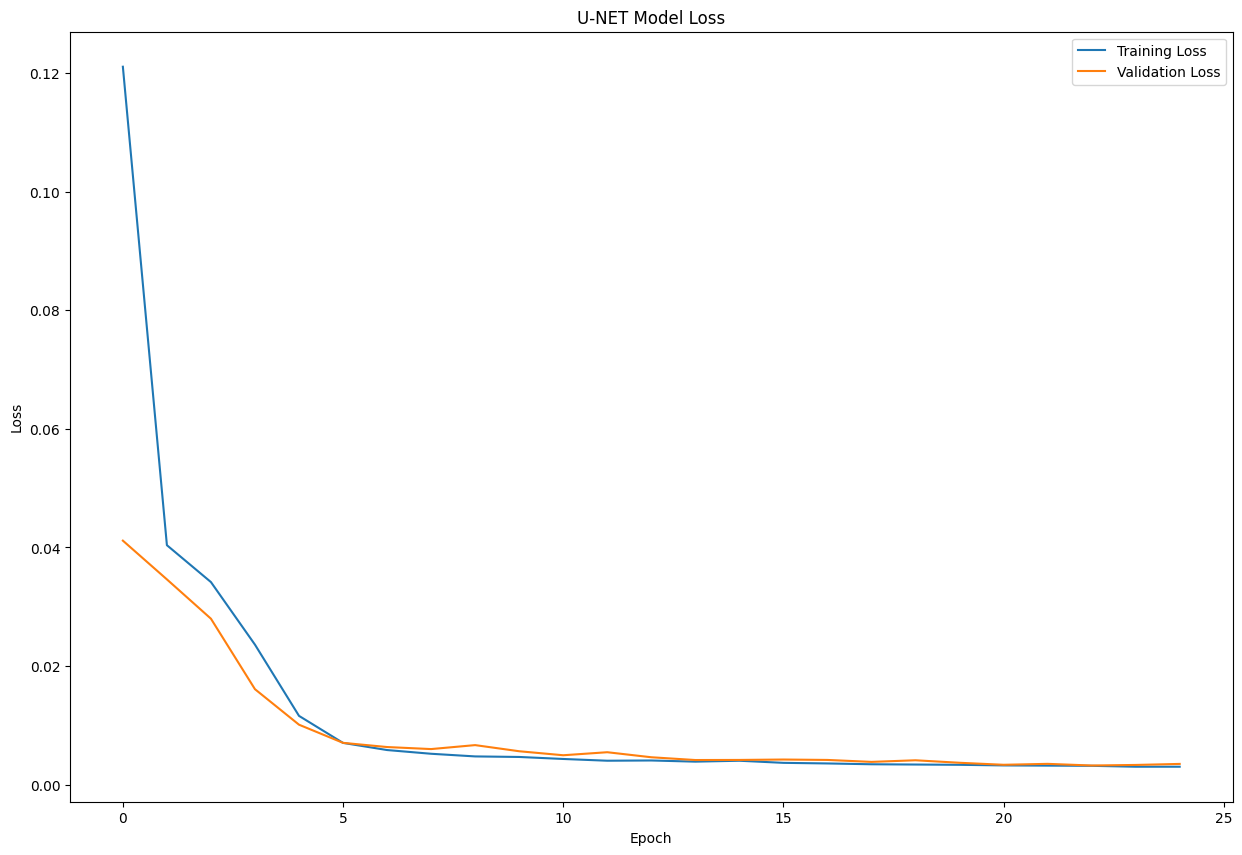

In [18]:
fig,ax  = plt.subplots(1, 1, figsize=(15, 10))

ax.plot(history.history['loss'], label='Training Loss')
ax.plot(history.history['val_loss'], label='Validation Loss')
ax.set_title('U-NET Model Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend(loc='upper right')
plt.show()
    


**Plot the Accuracy and Validation Accuracy**

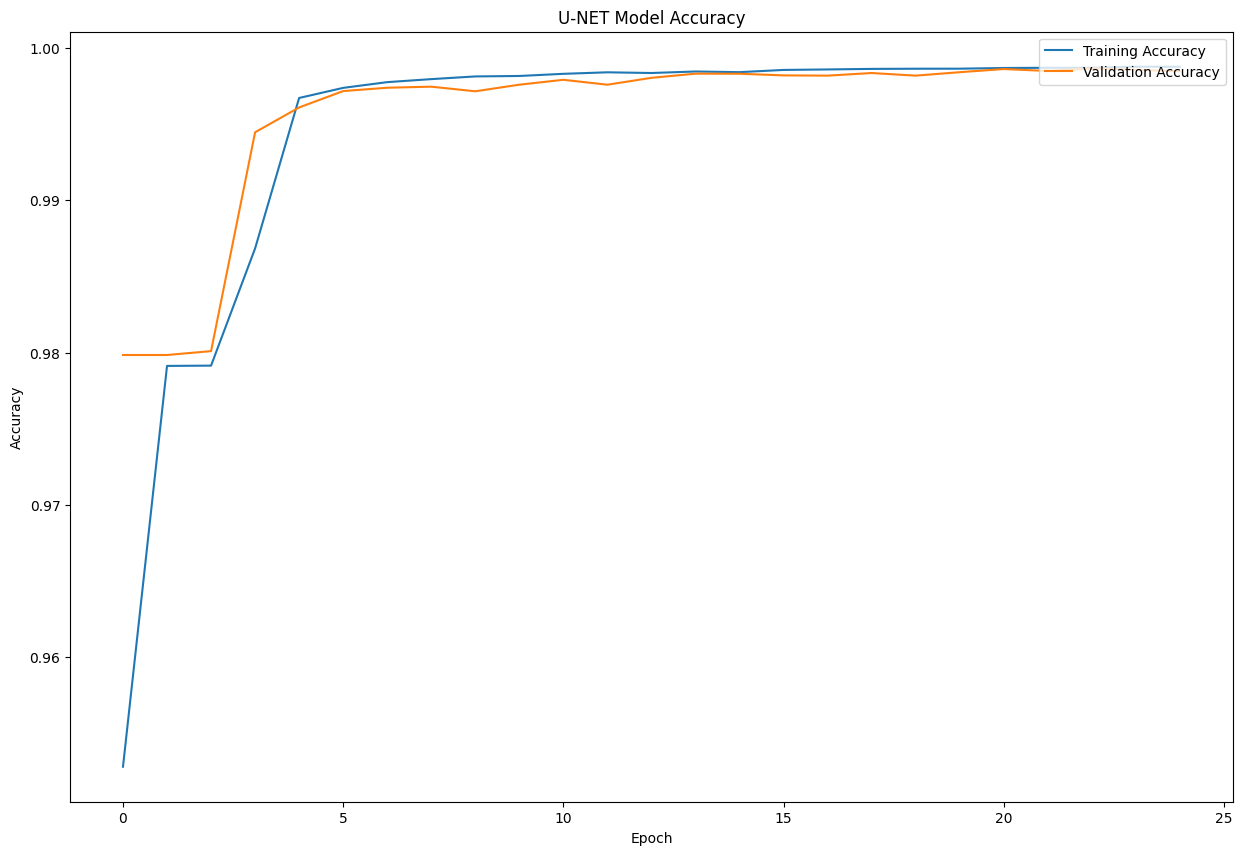

In [19]:
fig,ax  = plt.subplots(1, 1, figsize=(15, 10))
ax.plot(history.history['accuracy'], label='Training Accuracy')
ax.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax.set_title('U-NET Model Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend(loc='upper right')
plt.show()

**Predict the U-NET Model**

In [20]:
predicted_mask_test = unet_model.predict(X_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 226ms/step


In [21]:
predicted_mask_test[0].shape

(128, 128, 1)

In [22]:
X_test[0].shape

(128, 128, 1)

**Plotting image with test data**

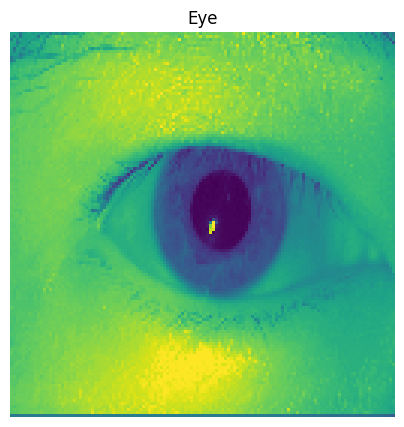

In [23]:
plt.figure(figsize = (5,5))
plt.imshow(X_test[0])
plt.axis('off')
plt.title("Eye")
plt.show()


**Iris recognition by U-NET**

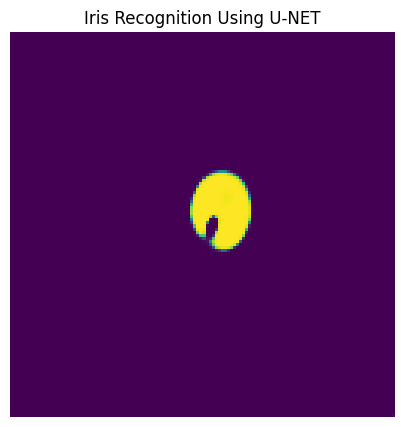

In [24]:
plt.figure(figsize = (5,5))
plt.imshow(predicted_mask_test[0])
plt.axis('off')
plt.title("Iris Recognition Using U-NET")
plt.show()

**Actual Iris recognition**

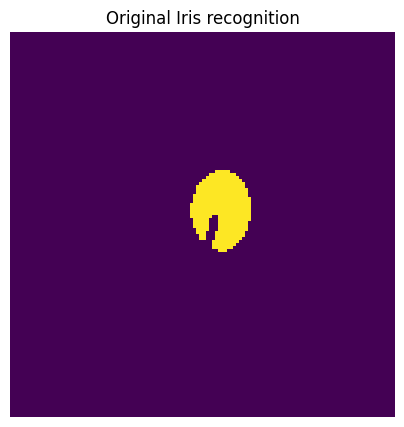

In [25]:
plt.figure(figsize = (5,5))
plt.imshow(Y_test[0])
plt.axis('off')
plt.title("Original Iris recognition")
plt.show()
